In [1]:
import helpers

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import joblib
import requests
from tqdm.auto import tqdm

from rectools import Columns
from rectools.models.popular import PopularModel
from rectools.dataset import Interactions, Dataset
from rectools.model_selection import TimeRangeSplitter
from rectools.metrics import Precision, Recall, MeanInvUserFreq, Serendipity, calc_metrics, MAP
from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender, BM25Recommender, ItemItemRecommender

from typing import Dict
from collections import Counter

from sklearn.preprocessing import MinMaxScaler

In [3]:
datasets = helpers.load_datasets('kion_train')

In [4]:
users, items, interactions = datasets.users, datasets.items, datasets.interactions
users = users[:150000].reset_index(drop=True)
users = users.reset_index(drop=True)
interactions = interactions[interactions['user_id'].isin(users['user_id'])].reset_index(drop=True)
items = items[items['item_id'].isin(interactions['item_id'])].reset_index(drop=True)

In [30]:
n_folds = 1
n_units = 1
unit = 'W'

In [31]:
last_date = datasets.interactions['datetime'].max().normalize()
cv = helpers.get_crossval_splitter(last_date, n_folds, n_units, unit)

In [18]:
(
    train_ids,
    test_ids,
    fold_info
) = cv.split(Interactions(df=interactions), collect_fold_stats=True).__next__()

In [5]:
train = interactions
test = interactions.loc[test_ids]

u_mappings = helpers.get_mappings(train, 'user_id')
i_mappings = helpers.get_mappings(train, 'item_id')

users_mapping, users_inv_mapping = u_mappings.direct, u_mappings.reverse
items_mapping, items_inv_mapping = i_mappings.direct, i_mappings.reverse

interaction_matrix = helpers.get_coo_mat(
    train,
    weights_column='weight',
    users_mapping=u_mappings,
    items_mapping=i_mappings,
)

In [6]:
interaction_matrix

<962179x15706 sparse matrix of type '<class 'numpy.int64'>'
	with 5476251 stored elements in COOrdinate format>

In [9]:
catalog = train['item_id'].unique()
metrics = {
    "map@10": MAP(k=10),
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

## Cosine Recommender

In [7]:
userknn = CosineRecommender(K=60)
userknn.fit(interaction_matrix)

  0%|          | 0/962179 [00:00<?, ?it/s]

In [10]:
import joblib

with open('cosine-k60.joblib', 'wb') as f:
    joblib.dump(userknn, f)

In [11]:
with open('users-mappings.joblib', 'wb') as f:
    joblib.dump(users_mapping, f)
    
with open('items-mappings.joblib', 'wb') as f:
    joblib.dump(items_mapping, f)

In [10]:
userknn = CosineRecommender(K=10)
userknn.fit(interaction_matrix)

mapper = helpers.get_implicit_recommendations_mapper(
    userknn,
    N=10,
    user_mapping=u_mappings,
)


recs = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

recs['similar_user_id'], recs['similarity'] = zip(*recs['user_id'].map(mapper))
recs = recs.set_index('user_id').apply(pd.Series.explode).reset_index()
recs = recs[~(recs['similarity'] >= 1)]

recs = helpers.join_watched(recs, train, use_dask=False)
recs = helpers.rank_from_sim(recs, train)

recs = recs[recs['rank'] < 11]

cosine_metrics = calc_metrics(
    metrics,
    reco=recs,
    interactions=test,
    prev_interactions=train,
    catalog=catalog
)

  0%|          | 0/117161 [00:00<?, ?it/s]

In [11]:
recs

,user_id,similar_user_id,similarity,item_id,idf,rank_idf,rank
0,1097337,769706,0.923201,7102,NaN,NaN,1
1,1097337,769706,0.923201,9728,NaN,NaN,2
2,1097337,769706,0.923201,15297,NaN,NaN,3
3,1097337,769706,0.923201,496,NaN,NaN,4
4,1097337,769706,0.923201,142,NaN,NaN,5
...,...,...,...,...,...,...,...
325660,53,762781,0.744246,1942,NaN,NaN,6
325661,53,762781,0.744246,1399,NaN,NaN,7
325662,53,762781,0.744246,12418,NaN,NaN,8
325663,53,762781,0.744246,14470,NaN,NaN,9


In [15]:
recs.shape

(3841, 7)

## TFIDF

In [53]:
userknn = TFIDFRecommender(K=10)
userknn.fit(interaction_matrix)

mapper = helpers.get_implicit_recommendations_mapper(
    userknn,
    N=10,
    user_mapping=u_mappings,
)


recs = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

recs['similar_user_id'], recs['similarity'] = zip(*recs['user_id'].map(mapper))
recs = recs.set_index('user_id').apply(pd.Series.explode).reset_index()
recs = recs[~(recs['similarity'] >= 1)]

recs = helpers.join_watched(recs, train, use_dask=False)
recs = helpers.rank_from_sim(recs, train)

recs = recs[recs['rank'] < 11]

tfidf_metrics = calc_metrics(
    metrics,
    reco=recs,
    interactions=test,
    prev_interactions=train,
    catalog=catalog
)

  0%|          | 0/117161 [00:00<?, ?it/s]

In [54]:
userknn = BM25Recommender(K=10)
userknn.fit(interaction_matrix)

mapper = helpers.get_implicit_recommendations_mapper(
    userknn,
    N=10,
    user_mapping=u_mappings,
)


recs = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

recs['similar_user_id'], recs['similarity'] = zip(*recs['user_id'].map(mapper))
recs = recs.set_index('user_id').apply(pd.Series.explode).reset_index()
# recs = recs[~(recs['similarity'] >= 1)]
recs = recs.drop_duplicates()
recs = recs[recs['user_id'] != recs['similar_user_id']]
recs['rank'] = recs.groupby('user_id').cumcount() + 1

recs = helpers.join_watched(recs, train, use_dask=False)
recs = helpers.rank_from_sim(recs, train)

recs = recs[recs['rank'] < 11]

bm25_metrics = calc_metrics(
    metrics,
    reco=recs,
    interactions=test,
    prev_interactions=train,
    catalog=catalog
)

  0%|          | 0/117161 [00:00<?, ?it/s]

In [55]:
metrics_df = pd.DataFrame([cosine_metrics, tfidf_metrics, bm25_metrics], index=['cosine', 'tfidf', 'bm25'])

In [56]:
metrics_df

,prec@10,recall@10,map@10,novelty,serendipity
cosine,0.004874,0.023246,0.005322,7.140111,0.000053
tfidf,0.005845,0.028124,0.007006,7.033803,0.000051
bm25,0.008934,0.044729,0.012968,8.423886,0.000100


In [40]:
metrics_df

,prec@10,recall@10,map@10,novelty,serendipity
cosine,0.005108,0.024167,0.005506,7.043247,0.000044
tfidf,0.006674,0.033422,0.007943,6.952556,0.000042
bm25,0.007745,0.038111,0.011041,8.412787,0.000057


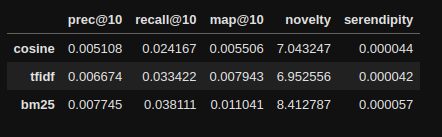

prec@10	| recall@10	map@10	novelty	serendipity
cosine	0.005108	0.024167	0.005506	7.043247	0.000044
tfidf	0.006674	0.033422	0.007943	6.952556	0.000042
bm25	0.007745	0.038111	0.011041	8.412787	0.000057

In [30]:
class UserKnn():
    """Class for fit-perdict UserKNN model 
       based on ItemKNN model from implicit.nearest_neighbours
    """
    
    def __init__(self, model: ItemItemRecommender, N_users: int = 50):
        self.N_users = N_users
        self.model = model
        self.is_fitted = False
        
    def get_mappings(self, train):
        self.users_inv_mapping = dict(enumerate(train['user_id'].unique()))
        self.users_mapping = {v: k for k, v in self.users_inv_mapping.items()}
        
        self.items_inv_mapping = dict(enumerate(train['item_id'].unique()))
        self.items_mapping = {v: k for k, v in self.items_inv_mapping.items()}
    
    def get_matrix(self, df: pd.DataFrame, 
                   user_col: str = 'user_id', 
                   item_col: str = 'item_id', 
                   weight_col: str = None, 
                   users_mapping: Dict[int, int] = None, 
                   items_mapping: Dict[int, int] = None):
    
        if weight_col:
            weights = df[weight_col].astype(np.float32)
        else:
            weights = np.ones(len(df), dtype=np.float32)

        interaction_matrix = sp.sparse.coo_matrix((
            weights, 
            (
                df[user_col].map(self.users_mapping.get), 
                df[item_col].map(self.items_mapping.get)
            )
            ))
        
        self.watched = df.groupby(user_col).agg({item_col: list})
        return interaction_matrix
        
    def idf(self, n: int, x: float):
        return np.log((1 + n) / (1 + x) + 1)
        
    def _count_item_idf(self, df: pd.DataFrame):
        item_cnt = Counter(df['item_id'].values)
        item_idf = pd.DataFrame.from_dict(item_cnt, orient='index', columns=['doc_freq']).reset_index()
        item_idf['idf'] = item_idf['doc_freq'].apply(lambda x: self.idf(self.n, x))
        self.item_idf = item_idf 
    
    def fit(self, train: pd.DataFrame):
        self.user_knn = self.model
        self.get_mappings(train)
        self.weights_matrix = self.get_matrix(train, users_mapping=self.users_mapping, 
                                             items_mapping=self.items_mapping)
        
        self.n = train.shape[0]
        self._count_item_idf(train)
        
        self.user_knn.fit(self.weights_matrix)
        self.is_fitted = True

    def _generate_recs_mapper(self, model: ItemItemRecommender, user_mapping: Dict[int, int], 
                              user_inv_mapping: Dict[int, int], N: int):
        def _recs_mapper(user):
            user_id = user_mapping[user]
            recs = model.similar_items(user_id, N=N)
            return [user_inv_mapping[user] for user, _ in recs], [sim for _, sim in recs]
        return _recs_mapper
    
    def predict(self, test: pd.DataFrame, N_recs: int = 10):
        
        if not self.is_fitted:
            raise ValueError("Please call fit before predict")
        
        mapper = self._generate_recs_mapper(
            model=self.user_knn, 
            user_mapping=self.users_mapping,
            user_inv_mapping=self.users_inv_mapping,
            N=self.N_users
        )

        recs = pd.DataFrame({'user_id': test['user_id'].unique()})
        recs['sim_user_id'], recs['sim'] = zip(*recs['user_id'].map(mapper))
        recs = recs.set_index('user_id').apply(pd.Series.explode).reset_index()
        
        recs = recs.merge(self.watched, left_on=['sim_user_id'], right_on=['user_id'], how='left')\
                    .explode('item_id')\
                    .sort_values(['user_id', 'sim'], ascending=False)\
                    .drop_duplicates(['user_id', 'item_id'], keep='first')\
                    .merge(self.item_idf, left_on='item_id', right_on='index', how='left')
        
        recs['score'] = recs['sim'] * recs['idf']
        recs = recs.sort_values(['user_id', 'score'], ascending=False)
        recs['rank'] = recs.groupby('user_id').cumcount() + 1 
        return recs[recs['rank'] <= N_recs][['user_id', 'item_id', 'score', 'rank']]

In [58]:
import optuna

In [59]:
interactions_df = Interactions(interactions)

In [60]:
models_map = {
    'cosine': CosineRecommender,
    'bm25': BM25Recommender,
    'tfidf': TFIDFRecommender,
}

In [61]:
n_folds = 4
unit = "W"
n_units = 1

last_date = interactions['datetime'].max().normalize()
start_date = last_date - pd.Timedelta(n_folds * n_units + 1, unit=unit)
periods = n_folds + 1
freq = f"{n_units}{unit}"

date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)

cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

In [62]:
study = optuna.create_study(direction="maximize", storage='sqlite:///userknn.db')
## 50k: no-name-e25c6236-adab-4199-a484-a34dc4a85346
## 150k: no-name-541219ca-9c4f-489c-bba0-49c2d2362221

[I 2022-12-07 15:28:48,983] A new study created in RDB with name: no-name-541219ca-9c4f-489c-bba0-49c2d2362221


In [21]:
objective = helpers.get_objective_for_optuna(cv, interactions_df,
                                             models_map, UserKnn, metrics)

In [63]:
study.optimize(objective, n_trials=30, timeout=1000)


==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:30:38,658] Trial 0 finished with value: 0.02124166531071164 and parameters: {'n_users': 36, 'model_name': 'cosine', 'all_days': False, 'days': 6}. Best is trial 0 with value: 0.02124166531071164.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:31:12,772] Trial 1 finished with value: 0.025924634051919925 and parameters: {'n_users': 12, 'model_name': 'tfidf', 'all_days': True, 'days': 2}. Best is trial 1 with value: 0.025924634051919925.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:31:53,800] Trial 2 finished with value: 0.019551203399764586 and parameters: {'n_users': 32, 'model_name': 'tfidf', 'all_days': True, 'days': 9}. Best is trial 1 with value: 0.025924634051919925.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:32:25,731] Trial 3 finished with value: 0.019387685103708613 and parameters: {'n_users': 14, 'model_name': 'bm25', 'all_days': False, 'days': 17}. Best is trial 1 with value: 0.025924634051919925.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:32:57,110] Trial 4 finished with value: 0.027862191193479224 and parameters: {'n_users': 11, 'model_name': 'cosine', 'all_days': True, 'days': 24}. Best is trial 4 with value: 0.027862191193479224.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:33:41,759] Trial 5 finished with value: 0.013461959080187992 and parameters: {'n_users': 37, 'model_name': 'bm25', 'all_days': True, 'days': 18}. Best is trial 4 with value: 0.027862191193479224.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:34:16,294] Trial 6 finished with value: 0.017576669123618348 and parameters: {'n_users': 18, 'model_name': 'bm25', 'all_days': False, 'days': 17}. Best is trial 4 with value: 0.027862191193479224.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:34:52,435] Trial 7 finished with value: 0.022552389241878384 and parameters: {'n_users': 28, 'model_name': 'cosine', 'all_days': False, 'days': 18}. Best is trial 4 with value: 0.027862191193479224.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:35:23,555] Trial 8 finished with value: 0.026796576968845808 and parameters: {'n_users': 15, 'model_name': 'cosine', 'all_days': False, 'days': 16}. Best is trial 4 with value: 0.027862191193479224.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:35:54,838] Trial 9 finished with value: 0.026586803045192415 and parameters: {'n_users': 16, 'model_name': 'cosine', 'all_days': False, 'days': 14}. Best is trial 4 with value: 0.027862191193479224.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:36:36,335] Trial 10 finished with value: 0.019036451841091866 and parameters: {'n_users': 45, 'model_name': 'cosine', 'all_days': True, 'days': 28}. Best is trial 4 with value: 0.027862191193479224.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:37:12,890] Trial 11 finished with value: 0.023219988508554078 and parameters: {'n_users': 23, 'model_name': 'cosine', 'all_days': True, 'days': 26}. Best is trial 4 with value: 0.027862191193479224.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:37:46,445] Trial 12 finished with value: 0.02960096673947527 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': False, 'days': 24}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:38:20,099] Trial 13 finished with value: 0.028572046615789458 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': True, 'days': 23}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:38:58,074] Trial 14 finished with value: 0.02284137959583447 and parameters: {'n_users': 21, 'model_name': 'tfidf', 'all_days': False, 'days': 22}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:39:30,844] Trial 15 finished with value: 0.028597689830466868 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': True, 'days': 22}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:40:14,704] Trial 16 finished with value: 0.018472511244102815 and parameters: {'n_users': 50, 'model_name': 'cosine', 'all_days': True, 'days': 21}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:40:51,743] Trial 17 finished with value: 0.024105155964803556 and parameters: {'n_users': 23, 'model_name': 'cosine', 'all_days': False, 'days': 11}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:41:31,186] Trial 18 finished with value: 0.02100605057056578 and parameters: {'n_users': 27, 'model_name': 'tfidf', 'all_days': False, 'days': 28}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:42:08,365] Trial 19 finished with value: 0.01715164299323037 and parameters: {'n_users': 18, 'model_name': 'bm25', 'all_days': True, 'days': 20}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:42:44,751] Trial 20 finished with value: 0.02381570089461192 and parameters: {'n_users': 21, 'model_name': 'cosine', 'all_days': True, 'days': 25}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:43:17,805] Trial 21 finished with value: 0.02854986544978305 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': True, 'days': 23}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:43:51,127] Trial 22 finished with value: 0.028560311244575406 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': True, 'days': 20}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:44:25,525] Trial 23 finished with value: 0.02633063624894105 and parameters: {'n_users': 14, 'model_name': 'cosine', 'all_days': True, 'days': 13}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:45:00,219] Trial 24 finished with value: 0.025247172826098833 and parameters: {'n_users': 17, 'model_name': 'cosine', 'all_days': True, 'days': 26}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:45:33,966] Trial 25 finished with value: 0.028524269437546535 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': True, 'days': 23}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:46:08,851] Trial 26 finished with value: 0.028002923320707855 and parameters: {'n_users': 13, 'model_name': 'cosine', 'all_days': False, 'days': 20}. Best is trial 12 with value: 0.02960096673947527.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

[I 2022-12-07 15:46:42,994] Trial 27 finished with value: 0.02449189713200104 and parameters: {'n_users': 19, 'model_name': 'cosine', 'all_days': True, 'days': 26}. Best is trial 12 with value: 0.02960096673947527.


In [65]:
trials_df = study.trials_dataframe()
trials_df[['params_model_name', 'params_n_users', 'value']].sort_values(['value'], ascending=False)

,params_model_name,params_n_users,value
12,cosine,10,0.029601
15,cosine,10,0.028598
13,cosine,10,0.028572
22,cosine,10,0.028560
21,cosine,10,0.028550
25,cosine,10,0.028524
26,cosine,13,0.028003
4,cosine,11,0.027862
8,cosine,15,0.026797
9,cosine,16,0.026587


In [84]:
MAP10_BASELINE_50k = study.best_trial.value
MAP10_BASELINE_50k

0.004343470405132799

 # MAP10_50K: 0.004343470405132799

In [22]:
def popular_number_of_items_days(
    df: pd.DataFrame, k: int = 10, days: int = 14, all_time: bool = False
) -> np.array:
    """
    Return a np.array of top@k most popular items for last N days
    """
    if all_time is True:
        recommendations = df.loc[:, "item_id"].value_counts().head(k).index.values
    else:
        min_date = df["datetime"].max().normalize() - pd.DateOffset(days)
        recommendations = (
            df.loc[df["datetime"] > min_date, "item_id"]
            .value_counts()
            .head(k)
            .index.values
        )
    return list(recommendations)

In [23]:
from userknn_techniques.v1 import my_UserKnn

In [36]:
def objective(trial):
    fold_iterator = cv.split(interactions_df, collect_fold_stats=True)

    map10_buffer = []

    for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
        print(f"\n==================== Fold {i_fold}")
        print(fold_info)

        df_train = interactions_df.df.iloc[train_ids].copy()
        df_test = interactions_df.df.iloc[test_ids].copy()

        catalog = df_train['item_id'].unique()

        n_user = trial.suggest_int('n_users', 10, 50)
        model_name = trial.suggest_categorical('model_name', ['cosine', 'bm25', 'tfidf'])
        all_time = trial.suggest_categorical('all_days', [True, False])
        days = trial.suggest_int('days', 1, 28)
        
        pop_items = popular_number_of_items_days(
            df_train, k=10, days=days, all_time=all_time
        )

        ModelType = models_map[model_name]

        userknn_model = my_UserKnn(model=ModelType(K=n_user),
                                   pop_items=pop_items, N_users=n_user)
        userknn_model.fit(df_train)

        recos = userknn_model.predict(df_test)

        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train,
            catalog=catalog,
        )

        fold = {"fold": i_fold, "model": model_name, 'n_users': n_user}
        fold.update(metric_values)

        map10_buffer.append(metric_values['map@10'])

    return np.array(map10_buffer).mean()

In [39]:
study2 = optuna.create_study(direction="maximize",
                             storage='sqlite:///userknn.db')
# no-name-e9cbcd21-6e9b-462b-a424-3f0299c1b099

[I 2022-12-07 15:09:01,528] A new study created in RDB with name: no-name-e9cbcd21-6e9b-462b-a424-3f0299c1b099


In [40]:
study.optimize(objective, n_trials=50)


==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:09:13,165] Trial 15 finished with value: 0.014464203638734192 and parameters: {'n_users': 45, 'model_name': 'tfidf', 'all_days': True, 'days': 21}. Best is trial 15 with value: 0.014464203638734192.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:09:24,284] Trial 16 finished with value: 0.01395895858399979 and parameters: {'n_users': 50, 'model_name': 'tfidf', 'all_days': True, 'days': 22}. Best is trial 15 with value: 0.014464203638734192.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:09:35,570] Trial 17 finished with value: 0.013969082784523528 and parameters: {'n_users': 50, 'model_name': 'tfidf', 'all_days': True, 'days': 22}. Best is trial 15 with value: 0.014464203638734192.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:09:45,752] Trial 18 finished with value: 0.014699178717932006 and parameters: {'n_users': 43, 'model_name': 'tfidf', 'all_days': True, 'days': 21}. Best is trial 18 with value: 0.014699178717932006.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:09:55,821] Trial 19 finished with value: 0.014960961103699032 and parameters: {'n_users': 41, 'model_name': 'tfidf', 'all_days': True, 'days': 13}. Best is trial 19 with value: 0.014960961103699032.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:10:07,129] Trial 20 finished with value: 0.010482041465816144 and parameters: {'n_users': 40, 'model_name': 'bm25', 'all_days': False, 'days': 7}. Best is trial 19 with value: 0.014960961103699032.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:10:17,034] Trial 21 finished with value: 0.015096600280861091 and parameters: {'n_users': 40, 'model_name': 'tfidf', 'all_days': True, 'days': 12}. Best is trial 21 with value: 0.015096600280861091.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:10:26,617] Trial 22 finished with value: 0.015369363586006537 and parameters: {'n_users': 38, 'model_name': 'tfidf', 'all_days': True, 'days': 9}. Best is trial 22 with value: 0.015369363586006537.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:10:37,305] Trial 23 finished with value: 0.01071848669280935 and parameters: {'n_users': 37, 'model_name': 'bm25', 'all_days': False, 'days': 2}. Best is trial 22 with value: 0.015369363586006537.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:10:44,990] Trial 24 finished with value: 0.02213023780453928 and parameters: {'n_users': 21, 'model_name': 'cosine', 'all_days': True, 'days': 12}. Best is trial 24 with value: 0.02213023780453928.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:10:52,479] Trial 25 finished with value: 0.022099263295418285 and parameters: {'n_users': 21, 'model_name': 'cosine', 'all_days': True, 'days': 8}. Best is trial 24 with value: 0.02213023780453928.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:11:00,173] Trial 26 finished with value: 0.02210303505578016 and parameters: {'n_users': 21, 'model_name': 'cosine', 'all_days': True, 'days': 8}. Best is trial 24 with value: 0.02213023780453928.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:11:07,563] Trial 27 finished with value: 0.02214328523336606 and parameters: {'n_users': 21, 'model_name': 'cosine', 'all_days': True, 'days': 5}. Best is trial 27 with value: 0.02214328523336606.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:11:14,997] Trial 28 finished with value: 0.022134804895558725 and parameters: {'n_users': 21, 'model_name': 'cosine', 'all_days': True, 'days': 4}. Best is trial 27 with value: 0.02214328523336606.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:11:22,415] Trial 29 finished with value: 0.0232005199520116 and parameters: {'n_users': 21, 'model_name': 'cosine', 'all_days': False, 'days': 2}. Best is trial 29 with value: 0.0232005199520116.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:11:29,700] Trial 30 finished with value: 0.02504782723814657 and parameters: {'n_users': 16, 'model_name': 'cosine', 'all_days': False, 'days': 1}. Best is trial 30 with value: 0.02504782723814657.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:11:36,851] Trial 31 finished with value: 0.024475720374134233 and parameters: {'n_users': 17, 'model_name': 'cosine', 'all_days': False, 'days': 1}. Best is trial 30 with value: 0.02504782723814657.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:11:43,925] Trial 32 finished with value: 0.024942559601656165 and parameters: {'n_users': 16, 'model_name': 'cosine', 'all_days': False, 'days': 1}. Best is trial 30 with value: 0.02504782723814657.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:11:51,053] Trial 33 finished with value: 0.024591617815350207 and parameters: {'n_users': 16, 'model_name': 'cosine', 'all_days': False, 'days': 28}. Best is trial 30 with value: 0.02504782723814657.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:11:58,215] Trial 34 finished with value: 0.025197755467190837 and parameters: {'n_users': 15, 'model_name': 'cosine', 'all_days': False, 'days': 26}. Best is trial 34 with value: 0.025197755467190837.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:12:05,305] Trial 35 finished with value: 0.0261264237344805 and parameters: {'n_users': 14, 'model_name': 'cosine', 'all_days': False, 'days': 17}. Best is trial 35 with value: 0.0261264237344805.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:12:12,519] Trial 36 finished with value: 0.026687270672934728 and parameters: {'n_users': 13, 'model_name': 'cosine', 'all_days': False, 'days': 17}. Best is trial 36 with value: 0.026687270672934728.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:12:19,607] Trial 37 finished with value: 0.026647135340879334 and parameters: {'n_users': 13, 'model_name': 'cosine', 'all_days': False, 'days': 17}. Best is trial 36 with value: 0.026687270672934728.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:12:26,231] Trial 38 finished with value: 0.02874515400070626 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': False, 'days': 17}. Best is trial 38 with value: 0.02874515400070626.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:12:33,089] Trial 39 finished with value: 0.028795764332292702 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': False, 'days': 17}. Best is trial 39 with value: 0.028795764332292702.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:12:39,828] Trial 40 finished with value: 0.028751351597010248 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': False, 'days': 17}. Best is trial 39 with value: 0.028795764332292702.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:12:46,940] Trial 41 finished with value: 0.028816563122140853 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': False, 'days': 17}. Best is trial 41 with value: 0.028816563122140853.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:12:53,842] Trial 42 finished with value: 0.028883008743459497 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': False, 'days': 19}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:13:00,666] Trial 43 finished with value: 0.019111039376281013 and parameters: {'n_users': 10, 'model_name': 'bm25', 'all_days': False, 'days': 19}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:13:08,041] Trial 44 finished with value: 0.024242286489666368 and parameters: {'n_users': 18, 'model_name': 'cosine', 'all_days': False, 'days': 14}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:13:16,295] Trial 45 finished with value: 0.02163242581218886 and parameters: {'n_users': 25, 'model_name': 'cosine', 'all_days': False, 'days': 20}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:13:23,175] Trial 46 finished with value: 0.027926016687637313 and parameters: {'n_users': 11, 'model_name': 'cosine', 'all_days': False, 'days': 16}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:13:29,985] Trial 47 finished with value: 0.028870110620216435 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': False, 'days': 19}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:13:36,872] Trial 48 finished with value: 0.027417315429565173 and parameters: {'n_users': 12, 'model_name': 'cosine', 'all_days': False, 'days': 19}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:13:43,758] Trial 49 finished with value: 0.02859506624534982 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': False, 'days': 24}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:13:51,056] Trial 50 finished with value: 0.023850854685112687 and parameters: {'n_users': 18, 'model_name': 'cosine', 'all_days': False, 'days': 23}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:13:58,157] Trial 51 finished with value: 0.016850788053503218 and parameters: {'n_users': 13, 'model_name': 'bm25', 'all_days': False, 'days': 19}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:14:05,375] Trial 52 finished with value: 0.027480317177737273 and parameters: {'n_users': 12, 'model_name': 'cosine', 'all_days': False, 'days': 15}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:14:13,916] Trial 53 finished with value: 0.020302266060923446 and parameters: {'n_users': 30, 'model_name': 'cosine', 'all_days': False, 'days': 21}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:14:21,011] Trial 54 finished with value: 0.02626779685823358 and parameters: {'n_users': 14, 'model_name': 'cosine', 'all_days': False, 'days': 15}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:14:27,679] Trial 55 finished with value: 0.01928372771312176 and parameters: {'n_users': 10, 'model_name': 'bm25', 'all_days': False, 'days': 11}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:14:34,744] Trial 56 finished with value: 0.028865757180258064 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': False, 'days': 18}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:14:41,606] Trial 57 finished with value: 0.027418930982573263 and parameters: {'n_users': 12, 'model_name': 'cosine', 'all_days': False, 'days': 18}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:14:48,637] Trial 58 finished with value: 0.02621072854110992 and parameters: {'n_users': 14, 'model_name': 'cosine', 'all_days': False, 'days': 21}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:14:55,487] Trial 59 finished with value: 0.028311459645377176 and parameters: {'n_users': 11, 'model_name': 'cosine', 'all_days': False, 'days': 14}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:15:03,059] Trial 60 finished with value: 0.02362284217480315 and parameters: {'n_users': 19, 'model_name': 'cosine', 'all_days': False, 'days': 20}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:15:10,836] Trial 61 finished with value: 0.021732598564905965 and parameters: {'n_users': 24, 'model_name': 'cosine', 'all_days': False, 'days': 23}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:15:17,846] Trial 62 finished with value: 0.028044206629600568 and parameters: {'n_users': 11, 'model_name': 'cosine', 'all_days': False, 'days': 16}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:15:24,993] Trial 63 finished with value: 0.025432921189962415 and parameters: {'n_users': 15, 'model_name': 'cosine', 'all_days': False, 'days': 18}. Best is trial 42 with value: 0.028883008743459497.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 169161, 'Train users': 31982, 'Train items': 6968, 'Test': 11257, 'Test users': 4190, 'Test items': 2342}


  0%|          | 0/31982 [00:00<?, ?it/s]


==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 185626, 'Train users': 34257, 'Train items': 7124, 'Test': 12258, 'Test users': 4592, 'Test items': 2368}


  0%|          | 0/34257 [00:00<?, ?it/s]


==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 203620, 'Train users': 36692, 'Train items': 7248, 'Test': 12410, 'Test users': 4719, 'Test items': 2308}


  0%|          | 0/36692 [00:00<?, ?it/s]


==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 221881, 'Train users': 39079, 'Train items': 7469, 'Test': 13046, 'Test users': 4855, 'Test items': 2431}


  0%|          | 0/39079 [00:00<?, ?it/s]

[I 2022-12-07 15:15:31,704] Trial 64 finished with value: 0.01845596734296169 and parameters: {'n_users': 10, 'model_name': 'bm25', 'all_days': True, 'days': 13}. Best is trial 42 with value: 0.028883008743459497.


In [64]:
trials_df = study2.trials_dataframe()
trials_df[['params_model_name', 'params_n_users', 'value']].sort_values(['value'], ascending=False)

,params_model_name,params_n_users,value
12,cosine,10,0.029601
15,cosine,10,0.028598
13,cosine,10,0.028572
22,cosine,10,0.028560
21,cosine,10,0.028550
25,cosine,10,0.028524
26,cosine,13,0.028003
4,cosine,11,0.027862
8,cosine,15,0.026797
9,cosine,16,0.026587


In [43]:
study.best_trial.value

0.028883008743459497

## MAP10_50K (Upgraded)

Prev: **0.004343470405132799**

Curr: **0.028883008743459497**

## MAP10_150K

1: 0.02960096673947527 and parameters: {'n_users': 10, 'model_name': 'cosine', 'all_days': False, 'days': 24}

2: 0.019387685103708613 and parameters: {'n_users': 14, 'model_name': 'bm25', 'all_days': False, 'days': 17}

3: 0.025924634051919925 and parameters: {'n_users': 12, 'model_name': 'tfidf', 'all_days': True, 'days': 2}

## Blanding

In [20]:
users, items, interactions = datasets.users, datasets.items, datasets.interactions
users = users[:150000].reset_index(drop=True)
interactions = interactions[interactions['user_id'].isin(users['user_id'])].reset_index(drop=True)
items = items[items['item_id'].isin(interactions['item_id'])].reset_index(drop=True)

interactions_df = Interactions(interactions)

In [21]:
from userknn_techniques.v2_blanding import UserKNN_Blanding3

In [12]:
def popular_number_of_items_days(
    df: pd.DataFrame, k: int = 10, days: int = 14, all_time: bool = False
) -> np.array:
    """
    Return a np.array of top@k most popular items for last N days
    """
    if all_time is True:
        recommendations = df.loc[:, "item_id"].value_counts().head(k).index.values
    else:
        min_date = df["datetime"].max().normalize() - pd.DateOffset(days)
        recommendations = (
            df.loc[df["datetime"] > min_date, "item_id"]
            .value_counts()
            .head(k)
            .index.values
        )
    return list(recommendations)

In [23]:
n_folds = 4
unit = "W"
n_units = 1

last_date = interactions['datetime'].max().normalize()
start_date = last_date - pd.Timedelta(n_folds * n_units + 1, unit=unit)
periods = n_folds + 1
freq = f"{n_units}{unit}"

date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)

cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

In [24]:
models_map = {
    'cosine': CosineRecommender,
    'bm25': BM25Recommender,
    'tfidf': TFIDFRecommender,
}

In [25]:
metrics = {
    "map@10": MAP(k=10),
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

In [26]:
def objective_blanded(trial):
    fold_iterator = cv.split(interactions_df, collect_fold_stats=True)
    map10_buff = []

    for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
        print(f"\n==================== Fold {i_fold}")
        print(fold_info)

        df_train = interactions_df.df.iloc[train_ids].copy()
        df_test = interactions_df.df.iloc[test_ids].copy()

        catalog = df_train['item_id'].unique()

        all_time = trial.suggest_categorical('all_time', [True, False])
        days = trial.suggest_int('days', 1, 28)

        pop_items = popular_number_of_items_days(
            df_train, k=10, days=days, all_time=all_time
        )
        
        model_type1 = trial.suggest_categorical('model1', ['cosine', 'bm25', 'tfidf'])
        model_type2 = trial.suggest_categorical('model2', ['cosine', 'bm25', 'tfidf'])
        model_type3 = trial.suggest_categorical('model3', ['cosine', 'bm25', 'tfidf'])

        model1 = models_map[model_type1](K=10)
        model2 = models_map[model_type2](K=10)
        model3 = models_map[model_type3](K=10)
        
        n_user = trial.suggest_int('n_users', 10, 50)
        
        w1 = trial.suggest_float('w1', 0.0, 1.0)
        w2 = trial.suggest_float('w2', 0.0, 1.0)
        w3 = trial.suggest_float('w3', 0.0, 1.0)

        userknn_model = UserKNN_Blanding3(model1, model2, model3, w1=w1, w2=w2, w3=w3,
                                          pop_items=pop_items, N_users=n_user)
        userknn_model.fit(df_train)

        recos = userknn_model.predict(df_test)

        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train,
            catalog=catalog,
        )

        fold = {"fold": i_fold, "model1": model1, "model2": model2, "model3": model3,
                'n_users': n_user}
        fold.update(metric_values)

        map10_buff.append(metric_values['map@10'])

    return np.array(map10_buff).mean()

In [27]:
import optuna

In [28]:
study = optuna.create_study(direction="maximize", storage='sqlite:///userknn.db')

# 50k: no-name-052d91f7-cba0-41d5-b014-1c66379bccfb
# 50k: with weights: no-name-fee147eb-e86e-4e7b-af3f-970e8d312765
# 150k (with weights): no-name-3a546a2e-785f-433e-a3ae-06eed3284b93

[I 2022-12-07 18:04:13,993] A new study created in RDB with name: no-name-3a546a2e-785f-433e-a3ae-06eed3284b93


In [29]:
study.optimize(objective_blanded, n_trials=25)


==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (95909, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (104655, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (107435, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (113059, 3)


[I 2022-12-07 18:06:09,056] Trial 0 finished with value: 0.02173117009772407 and parameters: {'all_time': True, 'days': 16, 'model1': 'bm25', 'model2': 'bm25', 'model3': 'cosine', 'n_users': 20, 'w1': 0.7831424802255524, 'w2': 0.7909358995272207, 'w3': 0.9814560995325423}. Best is trial 0 with value: 0.02173117009772407.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:07:22,165] Trial 1 finished with value: 0.0296253875791202 and parameters: {'all_time': False, 'days': 25, 'model1': 'cosine', 'model2': 'cosine', 'model3': 'cosine', 'n_users': 19, 'w1': 0.08963113134145984, 'w2': 0.6905790553300366, 'w3': 0.06543205412626707}. Best is trial 1 with value: 0.0296253875791202.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:08:37,540] Trial 2 finished with value: 0.028584343384266044 and parameters: {'all_time': True, 'days': 16, 'model1': 'cosine', 'model2': 'tfidf', 'model3': 'cosine', 'n_users': 13, 'w1': 0.951320077354751, 'w2': 0.17732581419895577, 'w3': 0.6025832965426499}. Best is trial 1 with value: 0.0296253875791202.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (95909, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (104655, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (107435, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (113059, 3)


[I 2022-12-07 18:09:50,620] Trial 3 finished with value: 0.022461401950870232 and parameters: {'all_time': False, 'days': 16, 'model1': 'bm25', 'model2': 'tfidf', 'model3': 'tfidf', 'n_users': 49, 'w1': 0.49988511891255993, 'w2': 0.6252979755791215, 'w3': 0.10056510224902415}. Best is trial 1 with value: 0.0296253875791202.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:11:01,659] Trial 4 finished with value: 0.030226762267094334 and parameters: {'all_time': False, 'days': 6, 'model1': 'cosine', 'model2': 'tfidf', 'model3': 'bm25', 'n_users': 25, 'w1': 0.03620249497851813, 'w2': 0.40656033940104175, 'w3': 0.49269354366943674}. Best is trial 4 with value: 0.030226762267094334.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (95909, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (104655, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (107435, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (113059, 3)


[I 2022-12-07 18:12:14,873] Trial 5 finished with value: 0.02176227700553469 and parameters: {'all_time': True, 'days': 16, 'model1': 'bm25', 'model2': 'cosine', 'model3': 'tfidf', 'n_users': 12, 'w1': 0.6199597795258914, 'w2': 0.35544749167296874, 'w3': 0.061943895293295914}. Best is trial 4 with value: 0.030226762267094334.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (95909, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (104655, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (107435, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (113059, 3)


[I 2022-12-07 18:13:25,635] Trial 6 finished with value: 0.02172506750188271 and parameters: {'all_time': True, 'days': 22, 'model1': 'bm25', 'model2': 'tfidf', 'model3': 'bm25', 'n_users': 15, 'w1': 0.12839977712813466, 'w2': 0.33668656750124837, 'w3': 0.07316767664077051}. Best is trial 4 with value: 0.030226762267094334.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (85039, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (92987, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (95183, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (99838, 3)


[I 2022-12-07 18:14:35,289] Trial 7 finished with value: 0.0284142415820815 and parameters: {'all_time': False, 'days': 15, 'model1': 'tfidf', 'model2': 'cosine', 'model3': 'cosine', 'n_users': 37, 'w1': 0.9266816418070901, 'w2': 0.10743922033854292, 'w3': 0.9263161864448232}. Best is trial 4 with value: 0.030226762267094334.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (85039, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (92987, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (95183, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (99838, 3)


[I 2022-12-07 18:15:44,504] Trial 8 finished with value: 0.027334569093631356 and parameters: {'all_time': True, 'days': 14, 'model1': 'tfidf', 'model2': 'cosine', 'model3': 'cosine', 'n_users': 38, 'w1': 0.10229755100170368, 'w2': 0.7430528491394554, 'w3': 0.3889519395588049}. Best is trial 4 with value: 0.030226762267094334.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (95909, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (104655, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (107435, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (113059, 3)


[I 2022-12-07 18:16:58,795] Trial 9 finished with value: 0.02173621947015266 and parameters: {'all_time': True, 'days': 6, 'model1': 'bm25', 'model2': 'tfidf', 'model3': 'bm25', 'n_users': 41, 'w1': 0.4733906653535481, 'w2': 0.3197065964652379, 'w3': 0.6317139078046373}. Best is trial 4 with value: 0.030226762267094334.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:18:13,972] Trial 10 finished with value: 0.030144411488154964 and parameters: {'all_time': False, 'days': 1, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 27, 'w1': 0.30277346086216783, 'w2': 0.9601474019484832, 'w3': 0.37327178782319625}. Best is trial 4 with value: 0.030226762267094334.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:19:27,277] Trial 11 finished with value: 0.030127391294699934 and parameters: {'all_time': False, 'days': 1, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 27, 'w1': 0.30275558361182503, 'w2': 0.9542094039208225, 'w3': 0.36537985705122167}. Best is trial 4 with value: 0.030226762267094334.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:20:37,166] Trial 12 finished with value: 0.030074708663276935 and parameters: {'all_time': False, 'days': 1, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 28, 'w1': 0.28961792644430306, 'w2': 0.514268402580363, 'w3': 0.33051061838794893}. Best is trial 4 with value: 0.030226762267094334.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:21:46,714] Trial 13 finished with value: 0.029997336017542103 and parameters: {'all_time': False, 'days': 7, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 32, 'w1': 0.005549976159871267, 'w2': 0.9785821594957548, 'w3': 0.7491371548344359}. Best is trial 4 with value: 0.030226762267094334.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:22:59,575] Trial 14 finished with value: 0.030075714444250373 and parameters: {'all_time': False, 'days': 7, 'model1': 'cosine', 'model2': 'tfidf', 'model3': 'bm25', 'n_users': 23, 'w1': 0.2985229990506508, 'w2': 0.488795684832026, 'w3': 0.24800172036395757}. Best is trial 4 with value: 0.030226762267094334.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:24:14,537] Trial 15 finished with value: 0.03042791312382214 and parameters: {'all_time': False, 'days': 4, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 32, 'w1': 0.21365604183443998, 'w2': 0.001645150343277224, 'w3': 0.5281082339188474}. Best is trial 15 with value: 0.03042791312382214.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:25:26,359] Trial 16 finished with value: 0.029978395991720523 and parameters: {'all_time': False, 'days': 10, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 33, 'w1': 0.198128034950525, 'w2': 0.19419003385208133, 'w3': 0.5169750898791835}. Best is trial 15 with value: 0.03042791312382214.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (85039, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (92987, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (95183, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (99838, 3)


[I 2022-12-07 18:26:37,057] Trial 17 finished with value: 0.028617286750050763 and parameters: {'all_time': False, 'days': 10, 'model1': 'tfidf', 'model2': 'tfidf', 'model3': 'tfidf', 'n_users': 45, 'w1': 0.022894430502183993, 'w2': 0.028897662074242526, 'w3': 0.780303716684579}. Best is trial 15 with value: 0.03042791312382214.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:27:48,144] Trial 18 finished with value: 0.030382645286127326 and parameters: {'all_time': False, 'days': 4, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 23, 'w1': 0.19934794195707484, 'w2': 0.004244156455073441, 'w3': 0.5005055948306945}. Best is trial 15 with value: 0.03042791312382214.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:28:59,265] Trial 19 finished with value: 0.030454974032857372 and parameters: {'all_time': False, 'days': 4, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 34, 'w1': 0.38272189882112434, 'w2': 0.01564792805376271, 'w3': 0.19815742183799168}. Best is trial 19 with value: 0.030454974032857372.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (85039, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (92987, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (95183, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (99838, 3)


[I 2022-12-07 18:30:11,424] Trial 20 finished with value: 0.028488663382827545 and parameters: {'all_time': False, 'days': 11, 'model1': 'tfidf', 'model2': 'bm25', 'model3': 'tfidf', 'n_users': 35, 'w1': 0.41220971901267256, 'w2': 0.21645357820906908, 'w3': 0.22378768254579062}. Best is trial 19 with value: 0.030454974032857372.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:31:22,453] Trial 21 finished with value: 0.03036124084348748 and parameters: {'all_time': False, 'days': 4, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 30, 'w1': 0.19788403043875205, 'w2': 0.010330149177674636, 'w3': 0.4992925078442249}. Best is trial 19 with value: 0.030454974032857372.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:32:40,257] Trial 22 finished with value: 0.030393102142297318 and parameters: {'all_time': False, 'days': 4, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 41, 'w1': 0.5955022764746618, 'w2': 0.07701613786822842, 'w3': 0.6615738486814859}. Best is trial 19 with value: 0.030454974032857372.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:33:48,260] Trial 23 finished with value: 0.03040589573896168 and parameters: {'all_time': False, 'days': 4, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 41, 'w1': 0.6339264687351814, 'w2': 0.10212530067274424, 'w3': 0.7107309432562418}. Best is trial 19 with value: 0.030454974032857372.



==================== Fold 0
{'Start date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'Train': 507101, 'Train users': 96298, 'Train items': 9563, 'Test': 33870, 'Test users': 12727, 'Test items': 3629}


  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

  0%|          | 0/96298 [00:00<?, ?it/s]

SHAPE (78790, 3)

==================== Fold 1
{'Start date': Timestamp('2021-07-25 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'Train': 555103, 'Train users': 102785, 'Train items': 9736, 'Test': 36409, 'Test users': 13695, 'Test items': 3632}


  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

  0%|          | 0/102785 [00:00<?, ?it/s]

SHAPE (86080, 3)

==================== Fold 2
{'Start date': Timestamp('2021-08-01 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'Train': 607865, 'Train users': 110035, 'Train items': 9909, 'Test': 37349, 'Test users': 14158, 'Test items': 3497}


  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

  0%|          | 0/110035 [00:00<?, ?it/s]

SHAPE (88913, 3)

==================== Fold 3
{'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'), 'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'), 'Train': 662260, 'Train users': 117161, 'Train items': 10124, 'Test': 39661, 'Test users': 14731, 'Test items': 3642}


  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

  0%|          | 0/117161 [00:00<?, ?it/s]

SHAPE (94152, 3)


[I 2022-12-07 18:34:53,694] Trial 24 finished with value: 0.029904939737269647 and parameters: {'all_time': False, 'days': 12, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 42, 'w1': 0.6066021998081036, 'w2': 0.12156563061435915, 'w3': 0.8027625631916482}. Best is trial 19 with value: 0.030454974032857372.


## MAP10_50K (BLANDING) - 0.029660289480684582

```json
{'all_time': False, 'days': 2, 'model1': 'bm25', 'model2': 'cosine', 'model3': 'tfidf', 'n_users': 48, 'w1': 0.6050326098624614, 'w2': 0.6343116490791555, 'w3': 0.12355175493172849}
```

## MAP10_150K (BLANDING) - 0.030454974032857372

```json
{'all_time': False, 'days': 4, 'model1': 'cosine', 'model2': 'bm25', 'model3': 'bm25', 'n_users': 34, 'w1': 0.38272189882112434, 'w2': 0.01564792805376271, 'w3': 0.19815742183799168}
```

In [20]:
users, items, interactions = datasets.users, datasets.items, datasets.interactions
users = users.reset_index(drop=True)
interactions = interactions[interactions['user_id'].isin(users['user_id'])].reset_index(drop=True)
items = items[items['item_id'].isin(interactions['item_id'])].reset_index(drop=True)

interactions_df = Interactions(interactions)

In [21]:
u_mappings = helpers.get_mappings(interactions, 'user_id')
i_mappings = helpers.get_mappings(interactions, 'item_id')

In [24]:
import joblib

with open('users-mapping.joblib', 'wb') as f:
    joblib.dump(u_mappings.direct, f)

In [25]:
with open('items-mapping.joblib', 'wb') as f:
    joblib.dump(i_mappings.direct, f)

In [43]:
(
    train_ids,
    test_ids,
    fold_info
) = cv.split(Interactions(df=interactions), collect_fold_stats=True).__next__()

In [44]:
train = interactions.loc[train_ids]
test = interactions.loc[test_ids]

u_mappings = helpers.get_mappings(train, 'user_id')
i_mappings = helpers.get_mappings(train, 'item_id')

users_mapping, users_inv_mapping = u_mappings.direct, u_mappings.reverse
items_mapping, items_inv_mapping = i_mappings.direct, i_mappings.reverse

interaction_matrix = helpers.get_coo_mat(
    train,
    weights_column='weight',
    users_mapping=u_mappings,
    items_mapping=i_mappings,
)

In [45]:
catalog = train['item_id'].unique()
metrics = {
    "map@10": MAP(k=10),
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

In [37]:
userknn_model = UserKnn(model=CosineRecommender(K=12), N_users=50)
userknn_model.fit(train)

  0%|          | 0/538988 [00:00<?, ?it/s]

In [39]:
import joblib

with open('userknn-baseline-cosine-wrapped.joblib', 'wb') as f:
    joblib.dump(userknn_model, f)

In [40]:
recos = userknn_model.predict(test)

metrics_baseline = calc_metrics(
    metrics,
    reco=recos,
    interactions=test,
    prev_interactions=train,
    catalog=catalog,
)

In [41]:
metrics_baseline

{'prec@10': 0.0025158986946334934,
 'recall@10': 0.014029497552042743,
 'map@10': 0.002310206243493135,
 'novelty': 7.883567342315782,
 'serendipity': 1.5840856744996122e-05}

```json
{'prec@10': 0.0025158986946334934,
 'recall@10': 0.014029497552042743,
 'map@10': 0.002310206243493135,
 'novelty': 7.883567342315782,
 'serendipity': 1.5840856744996122e-05}
```

In [46]:
all_time = False
days = 4

popular_items = popular_number_of_items_days(
    train, k=10, days=days, all_time=all_time
)

In [47]:
popular_items

[9728, 15297, 13865, 10440, 3734, 12192, 4495, 4151, 7829, 2657]

```json
{
    'all_time': False,
    'days': 4,
    'model1': 'cosine',
    'model2': 'bm25',
    'model3': 'bm25',
    'n_users': 34,
    'w1': 0.38272189882112434,
    'w2': 0.01564792805376271,
    'w3': 0.19815742183799168
}

In [48]:
blanded_model = UserKNN_Blanding3(
    model1=CosineRecommender(K=10),
    model2=BM25Recommender(K=10),
    model3=TFIDFRecommender(K=10),
    pop_items=popular_items,
    w1=0.3827,
    w2=0.2156,
    w3=0.0198,
)

In [50]:
blanded_model.fit(train)

  0%|          | 0/538988 [00:00<?, ?it/s]

  0%|          | 0/538988 [00:00<?, ?it/s]

  0%|          | 0/538988 [00:00<?, ?it/s]

In [52]:
import joblib


with open('blanded-test-model1-cosine.joblib', 'wb') as f:
    joblib.dump(blanded_model.model1, f)
    
with open('blanded-test-model2-bm25.joblib', 'wb') as f:
    joblib.dump(blanded_model.model2, f)
    
with open('blanded-test-model3-tfidf.joblib', 'wb') as f:
    joblib.dump(blanded_model.model3, f)

In [53]:
recos = blanded_model.predict(test)

metrics_blanded = calc_metrics(
    metrics,
    reco=recos,
    interactions=test,
    prev_interactions=train,
    catalog=catalog,
)

SHAPE (443807, 3)


In [54]:
metrics_blanded

{'prec@10': 0.02691621109003682,
 'recall@10': 0.15174474126265086,
 'map@10': 0.03252808430408894,
 'novelty': 6.136515698020157,
 'serendipity': 5.486892214458829e-05}

```json
{'prec@10': 0.02691621109003682,
 'recall@10': 0.15174474126265086,
 'map@10': 0.03252808430408894,
 'novelty': 6.136515698020157,
 'serendipity': 5.486892214458829e-05}
```

## Final train for service

In [8]:
users, items, interactions = datasets.users, datasets.items, datasets.interactions

In [9]:
interactions.shape

(5476251, 5)

In [14]:
from userknn_techniques.v2_blanding import UserKNN_Blanding3

all_time = False
days = 4

popular_items = popular_number_of_items_days(
    interactions, k=10, days=days, all_time=all_time
)

blanded_model = UserKNN_Blanding3(
    model1=CosineRecommender(K=10),
    model2=BM25Recommender(K=10),
    model3=TFIDFRecommender(K=10),
    pop_items=popular_items,
    w1=0.3827,
    w2=0.2156,
    w3=0.0198,
)

In [15]:
blanded_model.fit(interactions)

  0%|          | 0/962179 [00:00<?, ?it/s]

  0%|          | 0/962179 [00:00<?, ?it/s]

  0%|          | 0/962179 [00:00<?, ?it/s]

In [17]:
blanded_model

In [18]:
import joblib

with open('full-trained-blanded-wrapped.joblib', 'wb') as f:
    joblib.dump(blanded_model, f)

In [19]:
with open('full-trainded-blanded-model1-cosine.joblib', 'wb') as f:
    joblib.dump(blanded_model.model1, f)
    
with open('full-trainded-blanded-model2-bm25.joblib', 'wb') as f:
    joblib.dump(blanded_model.model2, f)
    
with open('full-trainded-blanded-model3-tfidf.joblib', 'wb') as f:
    joblib.dump(blanded_model.model3, f)

In [21]:
metrics = {
    "map@10": MAP(k=10),
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

In [22]:
recos = blanded_model.predict(interactions)

SHAPE (3990674, 3)


In [23]:
with open('predictions-dump-blanded.joblib', 'wb') as f:
    joblib.dump(recos, f)

In [25]:
recos.head(20)

,user_id,item_id,rank
0,0,2852,1
1,0,6006,2
2,0,7102,3
3,0,12192,4
4,0,9728,5
5,0,15297,6
6,0,10440,7
7,0,14488,8
8,0,512,9
9,0,4151,10


In [26]:
my_reco = recos.explode('item_id')

In [27]:
my_reco

,user_id,item_id,rank
0,0,2852,1
1,0,6006,2
2,0,7102,3
3,0,12192,4
4,0,9728,5
...,...,...,...
9621085,1097557,16270,6
9621086,1097557,4151,7
9621087,1097557,15297,8
9621088,1097557,9728,9


In [28]:
my_reco = (
  recos
  .groupby('user_id')
  .agg({'item_id': list})
)

In [29]:
my_reco

,item_id
user_id,
0,"[2852, 6006, 7102, 12192, 9728, 15297, 10440, ..."
1,"[3669, 10440, 9728, 15297, 14488, 13865, 12192..."
2,"[10267, 5819, 8482, 11287, 2306, 11689, 5438, ..."
3,"[9157, 1418, 13849, 10240, 2220, 14461, 10464,..."
4,"[6317, 9728, 15297, 10440, 14488, 13865, 12192..."
...,...
1097553,"[12659, 24, 12463, 9728, 15297, 10440, 14488, ..."
1097554,"[2496, 1053, 3509, 496, 12463, 9169, 16361, 84..."
1097555,"[416, 1465, 496, 8447, 13915, 12324, 14703, 44..."


In [34]:
my_reco.loc[0]['item_id']

[2852, 6006, 7102, 12192, 9728, 15297, 10440, 14488, 512, 4151]

In [44]:
my_reco['item_id']

user_id
0          [2852, 6006, 7102, 12192, 9728, 15297, 10440, ...
1          [3669, 10440, 9728, 15297, 14488, 13865, 12192...
2          [10267, 5819, 8482, 11287, 2306, 11689, 5438, ...
3          [9157, 1418, 13849, 10240, 2220, 14461, 10464,...
4          [6317, 9728, 15297, 10440, 14488, 13865, 12192...
                                 ...                        
1097553    [12659, 24, 12463, 9728, 15297, 10440, 14488, ...
1097554    [2496, 1053, 3509, 496, 12463, 9169, 16361, 84...
1097555    [416, 1465, 496, 8447, 13915, 12324, 14703, 44...
1097556    [12812, 9728, 15297, 10440, 14488, 13865, 1219...
1097557    [10700, 6470, 9982, 3182, 12623, 16270, 4151, ...
Name: item_id, Length: 962109, dtype: object

In [49]:
user_ids = my_reco['item_id'].index.unique()

In [64]:
import numpy as np
from tqdm.auto import tqdm

results = my_reco['item_id'].to_dict()

In [65]:
results

{0: [2852, 6006, 7102, 12192, 9728, 15297, 10440, 14488, 512, 4151],
 1: [3669, 10440, 9728, 15297, 14488, 13865, 12192, 341, 4151, 512],
 2: [10267, 5819, 8482, 11287, 2306, 11689, 5438, 10236, 383, 16029],
 3: [9157, 1418, 13849, 10240, 2220, 14461, 10464, 3784, 4436, 12192],
 4: [6317, 9728, 15297, 10440, 14488, 13865, 12192, 341, 4151, 3734],
 5: [11437, 15890, 12789, 3145, 2856, 6933, 14397, 7043, 8450, 14112],
 7: [8710, 9728, 15297, 10440, 14488, 13865, 12192, 341, 4151, 3734],
 8: [6809, 9728, 15297, 10440, 14488, 13865, 12192, 341, 4151, 3734],
 9: [1048, 341, 3076, 3784, 9996, 142, 8636, 4880, 2657, 3734],
 10: [10464, 13865, 9728, 15297, 10440, 14488, 12192, 341, 4151, 512],
 11: [16356, 5543, 16043, 10125, 12615, 14526, 16228, 4740, 12192, 6809],
 12: [846, 9728, 15297, 10440, 14488, 13865, 12192, 341, 4151, 3734],
 13: [8100, 10903, 10100, 2220, 598, 10464, 13915, 14, 14431, 14741],
 14: [1204, 10440, 9728, 15297, 14488, 13865, 12192, 341, 4151, 3734],
 15: [14500, 11739, 

In [66]:
reserved = {}

for key, value in tqdm(results.items()):
    if isinstance(value[0], np.ndarray):
        print(key)
        reserved[int(key)] = value[0].tolist()
    else:
        reserved[int(key)] = np.array(value).tolist()

  0%|          | 0/962109 [00:00<?, ?it/s]

In [67]:
len(reserved)

962109

In [68]:
import json

with open('blanded-precalculated.json', 'w') as f:
    json.dump(reserved, f)

In [69]:
popular_items

[9728, 15297, 10440, 14488, 13865, 12192, 341, 4151, 3734, 512]